In [218]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Control the default size of figures in this Jupyter notebook
%pylab inline
from bs4 import BeautifulSoup
import requests
import quandl
import json
import datetime as dt

Populating the interactive namespace from numpy and matplotlib


/home/samantoz/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
# Loading the Financial history data
# reusing the earlier database db_dsc540 for the final project
# Opening a connection object to connect to the database
# TableName: FinancialIndicator
with sqlite3.connect('db_dsc540') as conn:

    yr = ['2014','2015','2016','2017','2018']
    for i in range(5):
        yr[i]
        filename = "data/" + yr[i] +"_Financial_Data.csv"

        # defining the list of columns to load to the database
        column = ['Unnamed: 0','Revenue','Gross Profit','Operating Expenses','Operating Income','Interest Expense',
                 'Earnings before Tax','Net Income','EPS','Dividend per Share','Gross Margin','EBITDA',
                 'Revenue per Share','Net Income per Share','Market Cap','PE ratio','Price to Sales Ratio',
                 'Debt to Equity','Debt to Assets','Sector']
        df_fin_hist = pd.read_csv(filename, usecols=column)
        # Changing / Replace a column name in the dataframe
        df_fin_hist.rename(columns={'Unnamed: 0': 'Ticker'},inplace = True)
        df_fin_hist.insert(0, 'Year', yr[i])
        df_fin_hist.columns = [column.replace(' ','_') for column in df_fin_hist.columns]
        # write to the existing database into a new table
        df_fin_hist.to_sql('FinancialIndicator',conn, if_exists='append',index=False)
    # df_fin_hist.shape
    # df_fin_hist.head()


In [3]:
# Loading the End Of Day Ticker prices data 
# Database: db_dsc540
# TableName: eodstockprice

with sqlite3.connect('db_dsc540') as conn:
    list_of_ticker = ['AAPL','AMZN','LULU','BAC','T']
    for i in range(5):
        TK = list_of_ticker[i]
        print("Inserting Ticker",TK)
        url = "https://finance.yahoo.com/quote/" + TK + "/history?period1=1571443200&period2=1603065600&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true"
        resp = requests.get(url)
        soup = BeautifulSoup(resp.text, 'html.parser')
        data = soup.findAll('tr')
        headers = data[0]
        data_without_header = data[1:]
        col_headers = [th.getText() for th in headers.findAll('th')]
        df_url_data = [[td.getText() for td in tr.findAll('td')] for tr in data_without_header]
        df_eod_with_header = pd.DataFrame(df_url_data, columns=col_headers)
        df_eod_with_header.insert(0,'Ticker', TK)
        # remove the last row as it is the footer.
        df_eod_no_footer = df_eod_with_header[:-1]

        df_eod_no_footer.columns = [column.replace('*','') for column in df_eod_no_footer.columns]

        # write to the existing database into a new table
        df_eod_no_footer.to_sql('eodstockprice',conn, if_exists='append',index=False)

Inserting Ticker AAPL


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:2663: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


Inserting Ticker AMZN
Inserting Ticker LULU
Inserting Ticker BAC
Inserting Ticker T


In [269]:
# Open the quandlAPI.json file to read the api key
with open('quandlAPI.json') as f:
    keys = json.load(f)
    quandlapi = keys['api_key']

quandl.ApiConfig.api_key = quandlapi
# Loading the data from the API into a pandas dataframe
start = dt.date(2018,3,27)
end = dt.date(2018,3,27)
# data = quandl.get("FRED/GDP", start_date="2001-12-31", end_date="2005-12-31")
# data_aapl_tsp = quandl.get("WIKI/AAPL", rows=10)
# creating a list of tickers to be extracted using the API
df_api =[]
list_of_ticker = ['AAPL','AMZN','TSLA']
for i in range(len(list_of_ticker)):
    TK = list_of_ticker[i]
    # print(quandl.get('WIKI/'+TK, start_date=start, end_date=end))
    tmp_data = quandl.get('WIKI/'+TK, start_date=start, end_date=end)
    # Replace header to add the Ticker symbols for each stock
    tmp_data.insert(0,'Ticker', TK)
    df_api.append(tmp_data)

# api_data = pd.DataFrame(df_api) 
# df.shape
# df.tail()
# tmp_data.head

In [272]:
api_data = pd.DataFrame([df_api])
api_data

,0,1,2
0,Ticker Open High Low Cl...,Ticker Open High Low ...,Ticker Open High Low Clo...


In [63]:
# df_eod['Volume'] = df_eod['Volume'].str.replace(',', '').astype(float)
# df_eod[["Open","High","Low","Close*","Adj Close**"]] = df_eod[["Open","High","Low","Close*","Adj Close**"]].apply(pd.to_numeric) 
# df_eod[["Open","High"]] = df_eod[["Open","High"]].apply(pd.to_numeric) 

df_eod_no_footer.dtypes

Ticker       object
Date         object
Open         object
High         object
Low          object
Close        object
Adj Close    object
Volume       object
dtype: object

In [65]:
df_eod_no_footer.describe()

,Ticker,Date,Open,High,Low,Close,Adj Close,Volume
count,100,100,100,98,98,98,98,98
unique,1,98,99,95,97,97,97,98
top,AAPL,"Aug 31, 2020",110.40,99.25,110.00,91.03,90.71,"332,607,200"
freq,100,2,2,2,2,2,2,1


In [62]:
# Writing the SQL statements
cursor = conn.cursor()
sql_stmt = ''' select * from sqlite_master'''
rows = cursor.execute(sql_stmt)
for row in rows:
    print(row)

('table', 'customer', 'customer', 2, 'CREATE TABLE "customer" (\n\t"cust_name"\tTEXT NOT NULL,\n\t"cust_address"\tTEXT,\n\t"cust_city"\tTEXT,\n\t"cust_state"\tTEXT,\n\t"cust_zip"\tTEXT,\n\t"cust_phone"\tINTEGER\n)')
('table', 'FinancialIndicator', 'FinancialIndicator', 3, 'CREATE TABLE "FinancialIndicator" (\n"Ticker" TEXT,\n  "Revenue" REAL,\n  "Gross_Profit" REAL,\n  "Operating_Expenses" REAL,\n  "Operating_Income" REAL,\n  "Interest_Expense" REAL,\n  "Earnings_before_Tax" REAL,\n  "Net_Income" REAL,\n  "EPS" REAL,\n  "Dividend_per_Share" REAL,\n  "Gross_Margin" REAL,\n  "EBITDA" REAL,\n  "Revenue_per_Share" REAL,\n  "Net_Income_per_Share" REAL,\n  "Market_Cap" REAL,\n  "PE_ratio" REAL,\n  "Price_to_Sales_Ratio" REAL,\n  "Debt_to_Equity" REAL,\n  "Debt_to_Assets" REAL,\n  "Sector" TEXT\n)')
('table', 'eodstockprice', 'eodstockprice', 5, 'CREATE TABLE "eodstockprice" (\n"Ticker" TEXT,\n  "Date" TEXT,\n  "Open" REAL,\n  "High" REAL,\n  "Low" REAL,\n  "Close" REAL,\n  "Adj Close" REAL,\

In [4]:
# Reading from a sql query into a pandas dataframe 
sql_stmt = """select Ticker, count(*) from eodstockprice group by Ticker"""
with sqlite3.connect('db_dsc540') as conn:
    df_eod = pd.read_sql_query(sql_stmt,conn)

In [5]:
df_eod.shape

(5, 2)

In [6]:
df_eod.head

<bound method NDFrame.head of   Ticker  count(*)
0   AAPL       100
1   AMZN       100
2    BAC       100
3   LULU       100
4      T       100>

In [7]:
conn.close()

In [9]:
# Reading the data from the Financial Indicator table
with sqlite3.connect('db_dsc540') as conn:
    df = pd.read_sql_query('SELECT count(*) from FinancialIndicator',conn)
df    

,count(*)
0,22077


In [10]:
# sample each Ticker from this table
with sqlite3.connect('db_dsc540') as conn:
    df = pd.read_sql_query('''SELECT Ticker,count(*) from FinancialIndicator 
                  group by Ticker
                  ''',conn)
df

,Ticker,count(*)
0,A,5
1,AA,5
2,AABA,5
3,AAL,5
4,AAMC,5
...,...,...
4975,ZTR,4
4976,ZTS,5
4977,ZUMZ,5
4978,ZYME,3


In [11]:
# Show the Financial data for the following five companies by Ticker symbol
with sqlite3.connect('db_dsc540') as conn:
    df = pd.read_sql_query('''SELECT * from FinancialIndicator 
                  where Ticker in ('AAPL','AMZN','LULU','BAC','T')
                  ''',conn)
df

,Year,Ticker,Revenue,Gross_Profit,Operating_Expenses,Operating_Income,Interest_Expense,Earnings_before_Tax,Net_Income,EPS,...,Gross_Margin,EBITDA,Revenue_per_Share,Net_Income_per_Share,Market_Cap,PE_ratio,Price_to_Sales_Ratio,Debt_to_Equity,Debt_to_Assets,Sector
0,2014,LULU,1.591188e+09,8.400760e+08,4.487180e+08,3.913580e+08,0.000000e+00,3.971260e+08,2.795470e+08,1.93,...,0.5280,4.461940e+08,10.9803,1.9291,5.159717e+09,23.2021,3.2427,0.0000,0.0000,Consumer Cyclical
1,2014,T,1.324470e+11,7.230200e+10,6.009000e+10,1.221200e+10,3.613000e+09,1.006100e+10,6.442000e+09,1.24,...,0.5459,3.194700e+10,25.5344,1.2420,1.742313e+11,27.0887,1.3155,0.9121,0.2757,Communication Services
2,2014,BAC,8.589400e+10,8.589400e+10,7.565600e+10,1.023800e+10,0.000000e+00,7.963000e+09,5.520000e+09,0.43,...,1.0000,1.048500e+10,8.1588,0.5243,1.881393e+11,41.6047,2.1904,1.9534,0.2260,Financial Services
3,2014,AAPL,1.827950e+11,7.053700e+10,1.803400e+10,5.250300e+10,0.000000e+00,5.348300e+10,3.951000e+10,6.49,...,0.3859,6.142900e+10,30.0374,6.4924,5.994454e+11,15.4253,3.2793,0.3164,0.1522,Technology
4,2014,AMZN,8.898800e+10,2.623600e+10,2.605800e+10,1.780000e+08,2.100000e+08,-7.400000e+07,-2.410000e+08,-0.52,...,0.2948,4.882000e+09,192.6147,-0.5216,1.436941e+11,0.0000,1.6148,0.7695,0.1516,Technology
5,2015,LULU,1.797213e+09,9.141800e+08,5.381470e+08,3.760330e+08,0.000000e+00,3.831350e+08,2.390330e+08,1.66,...,0.5087,4.414990e+08,12.4863,1.6607,8.659118e+09,39.4699,4.8181,0.0000,0.0000,Consumer Cyclical
6,2015,T,1.468010e+11,7.975500e+10,5.497000e+10,2.478500e+10,4.120000e+09,2.035000e+10,1.334500e+10,2.37,...,0.5433,4.648600e+10,23.8623,2.1692,2.116903e+11,14.5190,1.4420,1.0284,0.3133,Communication Services
7,2015,BAC,8.296500e+10,8.296500e+10,5.761700e+10,2.534800e+10,0.000000e+00,2.218700e+10,1.591000e+10,1.38,...,1.0000,2.457600e+10,7.9299,1.5207,1.752420e+11,12.1957,2.1122,1.7143,0.2048,Financial Services
8,2015,AAPL,2.337150e+11,9.362600e+10,2.239600e+10,7.123000e+10,0.000000e+00,7.251500e+10,5.339400e+10,9.28,...,0.4006,8.377200e+10,40.6219,9.2804,6.412141e+11,12.1164,2.7436,0.5390,0.2216,Technology
9,2015,AMZN,1.070060e+11,3.535500e+10,3.312200e+10,2.233000e+09,4.590000e+08,1.546000e+09,5.960000e+08,1.28,...,0.3304,8.286000e+09,229.1349,1.2762,3.168316e+11,528.0391,2.9609,0.6147,0.1271,Technology


In [12]:
# showing the sum of Revenue by the Sector
with sqlite3.connect('db_dsc540') as conn:
    df = pd.read_sql_query('''SELECT SECTOR,sum(Revenue)/(10000000) as Rev
                     from FinancialIndicator 
                     group by Sector
                     order by Rev
                     ''',conn)
df

,Sector,Rev
0,Real Estate,1.094282e+05
1,Utilities,2.723602e+05
2,Basic Materials,4.771353e+05
3,Communication Services,7.997535e+05
4,Industrials,1.047735e+06
5,Healthcare,1.073646e+06
6,Consumer Defensive,1.102046e+06
7,Technology,1.128520e+06
8,Consumer Cyclical,1.428307e+06
9,Energy,1.433297e+06


In [13]:
# Cleaning the data from the tables before loading into a dataframe 
sql_stmt = """select * from eodstockprice where Volume is null"""
with sqlite3.connect('db_dsc540') as conn:
    df_eod = pd.read_sql_query(sql_stmt,conn)

In [14]:
df_eod.head

<bound method NDFrame.head of   Ticker          Date             Open  High   Low Close Adj Close Volume
0   AAPL  Aug 31, 2020  4:1 Stock Split  None  None  None      None   None
1   AAPL  Aug 07, 2020   0.205 Dividend  None  None  None      None   None
2    BAC  Sep 03, 2020    0.18 Dividend  None  None  None      None   None
3    BAC  Jun 04, 2020    0.18 Dividend  None  None  None      None   None
4      T  Oct 08, 2020    0.52 Dividend  None  None  None      None   None
5      T  Jul 09, 2020    0.52 Dividend  None  None  None      None   None>

In [15]:
# Delete data from a table
del_stmt = """delete from eodstockprice where Volume is null"""
with sqlite3.connect('db_dsc540') as conn:
    cursor = conn.cursor()
    cursor.execute(del_stmt)
    conn.commit()

In [112]:
# Get the data for the closing pice for each ticker by date
sql_stmt = """ select Ticker, Date, "Adj Close" from eodstockprice"""
with sqlite3.connect('db_dsc540') as conn:
    df1 = pd.read_sql_query(sql_stmt,conn)

In [115]:
# df1[["Adj Close"]] = df1[["Adj Close"]].apply(pd.to_numeric)
df1['Adj Close'] = df1['Adj Close'].str.replace(',', '').astype(float)
df1.head

<bound method NDFrame.head of     Ticker          Date  Adj Close
0     AAPL  Oct 16, 2020     118.82
1     AAPL  Oct 15, 2020     120.50
2     AAPL  Oct 14, 2020     120.98
3     AAPL  Oct 13, 2020     120.89
4     AAPL  Oct 12, 2020     124.19
..     ...           ...        ...
489      T  Jun 05, 2020      31.63
490      T  Jun 04, 2020      30.69
491      T  Jun 03, 2020      30.41
492      T  Jun 02, 2020      29.91
493      T  Jun 01, 2020      29.85

[494 rows x 3 columns]>

In [97]:
list_of_ticker = ['AAPL','AMZN','LULU','BAC','T']
for i in range(5):
    TK = list_of_ticker[i]
    print("Inserting Ticker",TK)

Inserting Ticker AAPL
Inserting Ticker AMZN
Inserting Ticker LULU
Inserting Ticker BAC
Inserting Ticker T


In [16]:
# Creating a dataframe showing Year, Ticker, Revenue and Gross Profit
sql_stmt = """select Year,Ticker,
              (Revenue/1000000) as "Rev",
              Gross_Profit/1000000 as "GrossProfit"
              from FinancialIndicator 
              where Ticker in ('AAPL','AMZN','LULU','BAC','T')
              and Year = '2014'"""
with sqlite3.connect('db_dsc540') as conn:
    df_rev_profit = pd.read_sql_query(sql_stmt,conn)

In [17]:
df_rev_profit.shape

(5, 4)

In [202]:
# Visualization -1
# Bar Chart showing year wise Rev and GrossProfit

df_rev_profit

,Year,Ticker,Rev,GrossProfit
0,2014,LULU,1591.188,840.076
1,2014,T,132447.000,72302.000
2,2014,BAC,85894.000,85894.000
3,2014,AAPL,182795.000,70537.000
4,2014,AMZN,88988.000,26236.000


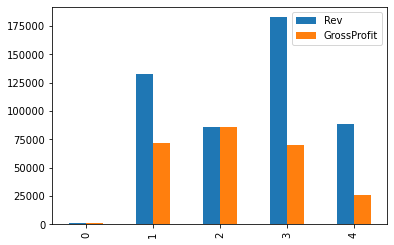

In [181]:
data = df_rev_profit[['Ticker','Rev','GrossProfit']]
data.plot.bar()

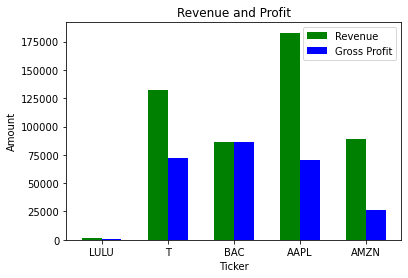

In [208]:
Year = df_rev_profit['Year']
Revenue = df_rev_profit['Rev']
GrossProfit = df_rev_profit['GrossProfit']
Ticker = df_rev_profit['Ticker']

index = np.arange(5)
width = 0.30

plt.bar(index,Revenue,width,color='green', label='Revenue')
plt.bar(index+width,GrossProfit,width,color='blue', label='Gross Profit')

plt.title('Revenue and Profit')
plt.ylabel('Amount')
plt.xlabel('Ticker')

plt.xticks(index + width/2,Ticker)

plt.legend(loc = 'best')
plt.show()

In [209]:
# Pair plot for each ticker showing the price movement for each day
# Creating a dataframe showing Year, Ticker, Revenue and Gross Profit
sql_stmt = """select *
              from eodstockprice 
              """
with sqlite3.connect('db_dsc540') as conn:
    df_eod_price = pd.read_sql_query(sql_stmt,conn)

In [210]:
df_eod_price

,Ticker,Date,Open,High,Low,Close,Adj Close,Volume
0,AAPL,"Oct 16, 2020",121.28,121.55,118.81,119.02,118.82,"115,393,800"
1,AAPL,"Oct 15, 2020",118.72,121.20,118.15,120.71,120.50,"112,559,200"
2,AAPL,"Oct 14, 2020",121.00,123.03,119.62,121.19,120.98,"151,062,300"
3,AAPL,"Oct 13, 2020",125.27,125.39,119.65,121.10,120.89,"262,330,500"
4,AAPL,"Oct 12, 2020",120.06,125.18,119.28,124.40,124.19,"240,226,800"
...,...,...,...,...,...,...,...,...
489,T,"Jun 05, 2020",32.54,33.00,32.23,32.77,31.63,"46,689,400"
490,T,"Jun 04, 2020",31.39,31.80,31.28,31.80,30.69,"30,762,800"
491,T,"Jun 03, 2020",31.30,31.66,31.28,31.51,30.41,"27,861,300"
492,T,"Jun 02, 2020",31.05,31.10,30.71,30.99,29.91,"28,437,000"


In [238]:
sql_stmt = """select Ticker,Date,Open,High,Low,
              cast("Adj Close" as REAL) as "AdjClose",Volume
              from eodstockprice
              """
with sqlite3.connect('db_dsc540') as conn:
    stock = pd.read_sql_query(sql_stmt,conn,index_col=("Date"))

In [230]:
pd.read_sql_query?

Signature:
pd.read_sql_query(
    sql,
    con,
    index_col=None,
    coerce_float=True,
    params=None,
    parse_dates=None,
    chunksize=None,
)
Docstring:
Read SQL query into a DataFrame.

Returns a DataFrame corresponding to the result set of the query
string. Optionally provide an `index_col` parameter to use one of the
columns as the index, otherwise default integer index will be used.

Parameters
----------
sql : str SQL query or SQLAlchemy Selectable (select or text object)
    SQL query to be executed.
con : SQLAlchemy connectable(engine/connection), database str URI,
    or sqlite3 DBAPI2 connection
    Using SQLAlchemy makes it possible to use any DB supported by that
    library.
    If a DBAPI2 object, only sqlite3 is supported.
index_col : str or list of strings, optional, default: None
    Column(s) to set as index(MultiIndex).
coerce_float : bool, default True
    Attempts to convert values of non-string, non-numeric objects (like
    decimal.Decimal) to floating p

In [246]:
stock

,Ticker,Open,High,Low,AdjClose,Volume
Date,,,,,,
"Oct 16, 2020",AAPL,121.28,121.55,118.81,118.82,"115,393,800"
"Oct 15, 2020",AAPL,118.72,121.20,118.15,120.50,"112,559,200"
"Oct 14, 2020",AAPL,121.00,123.03,119.62,120.98,"151,062,300"
"Oct 13, 2020",AAPL,125.27,125.39,119.65,120.89,"262,330,500"
"Oct 12, 2020",AAPL,120.06,125.18,119.28,124.19,"240,226,800"
...,...,...,...,...,...,...
"Jun 05, 2020",T,32.54,33.00,32.23,31.63,"46,689,400"
"Jun 04, 2020",T,31.39,31.80,31.28,30.69,"30,762,800"
"Jun 03, 2020",T,31.30,31.66,31.28,30.41,"27,861,300"


In [249]:
apple = stock[stock['Ticker']=='AAPL']
amazon = stock[stock['Ticker']=='AMZN']
bac = stock[stock['Ticker']=='BAC']
tesla = stock[stock['Ticker']=='T']
lululemon = stock[stock['Ticker']=='LULU']

In [250]:
all_stocks = pd.DataFrame({"AAPL": apple["AdjClose"],
                      "AMZN": amazon["AdjClose"],
                      "BAC": bac["AdjClose"],
                      "T": tesla["AdjClose"],
                      "LULU": lululemon["AdjClose"]})
all_stocks.head()

,AAPL,AMZN,BAC,T,LULU
"Aug 03, 2020",108.55,3.0,24.82,29.09,328.59
"Aug 04, 2020",109.28,3.0,24.84,29.47,328.21
"Aug 05, 2020",109.68,3.0,25.21,29.31,340.42
"Aug 06, 2020",113.50,3.0,25.29,29.30,339.18
"Aug 07, 2020",110.92,3.0,25.93,29.48,342.12


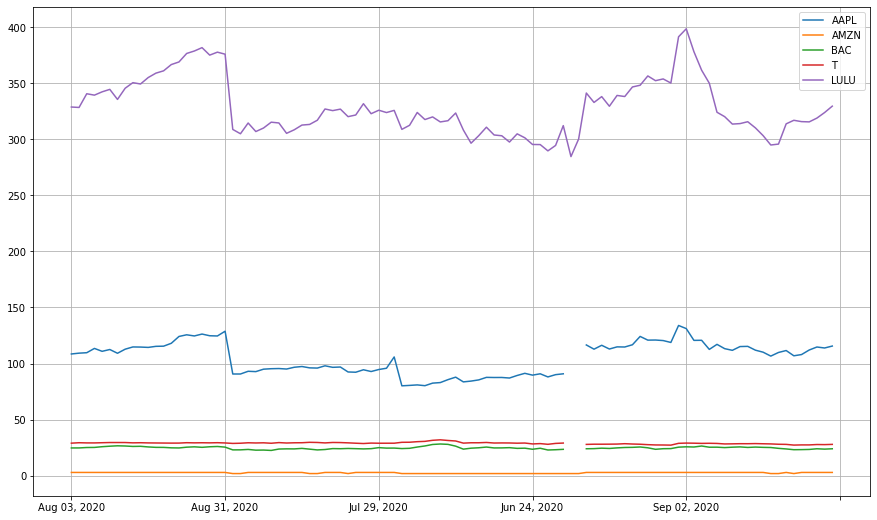

In [252]:
all_stocks.plot(grid = True);

In [253]:
apple[["AdjClose"]]

,AdjClose
Date,
"Oct 16, 2020",118.82
"Oct 15, 2020",120.50
"Oct 14, 2020",120.98
"Oct 13, 2020",120.89
"Oct 12, 2020",124.19
...,...
"Jun 05, 2020",82.58
"Jun 04, 2020",80.30
"Jun 03, 2020",80.99


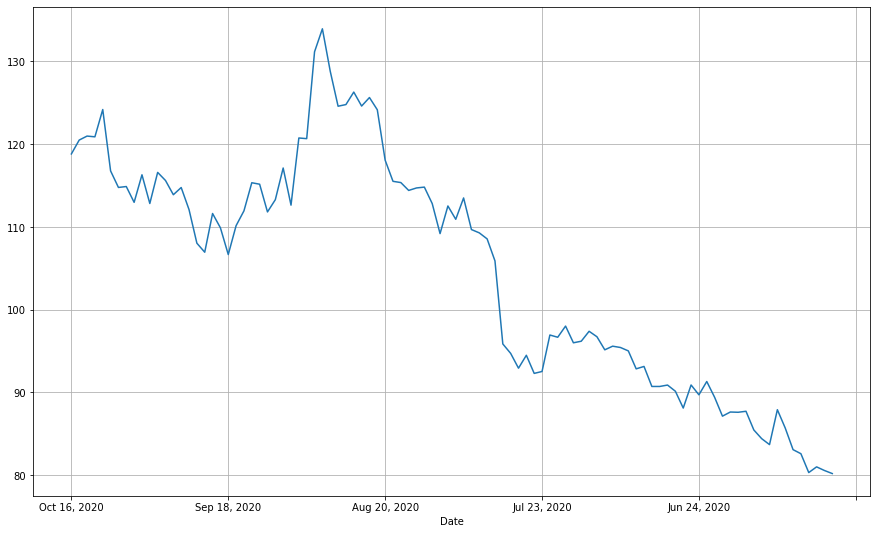

In [254]:
# The below chart shows the movement of the stock closing price for Apple shares Jun 2020 till Oct 2020.

pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots
apple["AdjClose"].plot(grid = True) # Plot the adjusted closing price of AAPL

In [279]:
# Creating a new dataframe joining the 2 tables
# FinancialIndicator
# eodstockprice
# The combined dataframe shows
# Year, Ticker, Revenue and Gross Profit
sql_stmt = """select Year,Ticker,
              cast(Market_Cap/100000000 as REAL) as "Market_Cap"
              from FinancialIndicator 
              where Ticker in ('AAPL','AMZN','LULU','BAC','T')
              and Year = '2018'"""

with sqlite3.connect('db_dsc540') as conn:
    df_mkt_cap = pd.read_sql_query(sql_stmt,conn)

In [294]:
sql_stmt = """select B.Year, A.Ticker,
              max(cast(A.Volume as REAL)) as "Volume",
              max(cast(B.Market_Cap/100000000 as REAL)) as "Market_Cap"
              from eodstockprice as A
                  inner join FinancialIndicator as B
                      on A.Ticker = B.Ticker
              where B.Ticker in ('AAPL','AMZN','LULU','BAC','T')
              and B.Year = '2018'
              group by A.Ticker,B.Year
              """

with sqlite3.connect('db_dsc540') as conn:
    df_vol = pd.read_sql_query(sql_stmt,conn)

In [295]:
df_vol

,Year,Ticker,Volume,Market_Cap
0,2018,AAPL,374.0,10976.489828
1,2018,AMZN,8.0,7344.162102
2,2018,BAC,149.0,2418.218107
3,2018,LULU,920.0,100.429013
4,2018,T,76.0,2077.141200


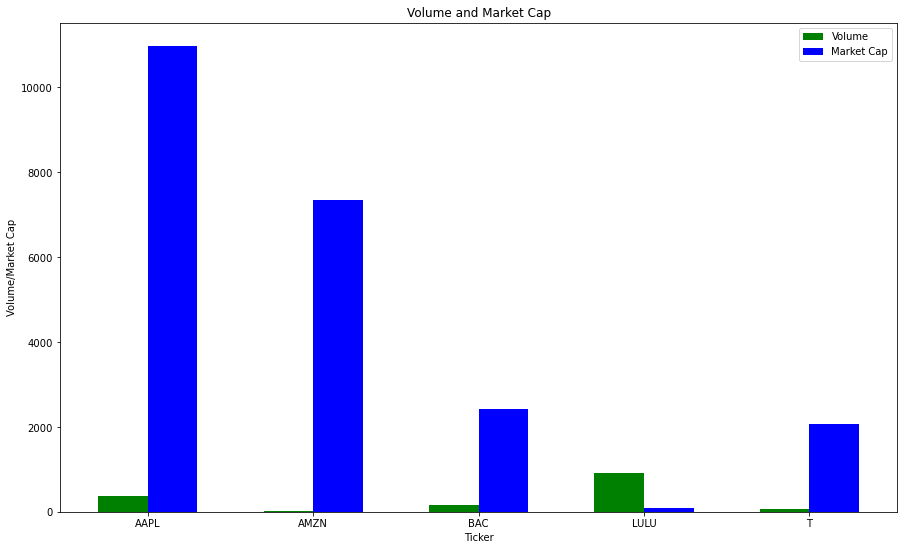

In [299]:
# This visualization shows the combined data using the Volume and Market Cap from 2 tables.

Vol = df_vol['Volume']
mcap = df_vol['Market_Cap']
Ticker = df_vol['Ticker']

index = np.arange(5)
width = 0.30

plt.bar(index,Vol,width,color='green', label='Volume')
plt.bar(index+width,mcap,width,color='blue', label='Market Cap')

plt.title('Volume and Market Cap')
plt.ylabel('Volume/Market Cap')
plt.xlabel('Ticker')

plt.xticks(index + width/2,Ticker)

plt.legend(loc = 'best')
plt.show()